In [ ]:
! unzip lish-moa.zip

Archive:  lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_drug.csv          
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  


In [ ]:
! mkdir data/
! mv *csv data/

## Import Libraries

In [ ]:
import os
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Load dataset

In [ ]:
train_features_df = pd.read_csv('data/train_features.csv')
test_features_df = pd.read_csv('data/test_features.csv')
train_targets_scored_df = pd.read_csv('data/train_targets_scored.csv')
train_targets_nonscored_df = pd.read_csv('data/train_targets_nonscored.csv')
train_drug_df = pd.read_csv('data/train_drug.csv')
sub = pd.read_csv('data/sample_submission.csv')


In [ ]:
# Make a copy of train and test features
train_features_copy = train_features_df.copy()
test_features_copy = test_features_df.copy()

## Overview: Features

- features `g-`: gene expression data
- features `c-`: cell viability data
- `cp_type`: samples treated without a compound
- `trt_cp`: samples treated with a compound
- `cp_vehicle` or with a control perturbation (`ctrl_vehicle`): control perturbations have no MoAs
- `cp_time` and `cp_dose`: treatment duration (24, 48, 72 hrs) and dose (high or low) respectively

## Explore Train & Test Features

In [ ]:
print('Training Features Samples')
display(train_features_df.head())

print('Training Features Description')
display(train_features_df.describe())

Training Features Samples


sig_id cp_type  cp_time cp_dose  ...    c-96    c-97    c-98    c-99
0  id_000644bb2  trt_cp       24      D1  ... -0.3981  0.2139  0.3801  0.4176
1  id_000779bfc  trt_cp       72      D1  ...  0.1522  0.1241  0.6077  0.7371
2  id_000a6266a  trt_cp       48      D1  ... -0.6417 -0.2187 -1.4080  0.6931
3  id_0015fd391  trt_cp       48      D1  ... -1.6210 -0.8784 -0.3876 -0.8154
4  id_001626bd3  trt_cp       72      D2  ...  0.1094  0.2885 -0.3786  0.7125

[5 rows x 876 columns]

Training Features Description


cp_time           g-0  ...          c-98          c-99
count  23814.000000  23814.000000  ...  23814.000000  23814.000000
mean      48.020156      0.248366  ...     -0.470252     -0.301505
std       19.402807      1.393399  ...      1.834828      1.407918
min       24.000000     -5.513000  ...    -10.000000    -10.000000
25%       24.000000     -0.473075  ...     -0.592600     -0.562900
50%       48.000000     -0.008850  ...      0.014000     -0.019500
75%       72.000000      0.525700  ...      0.461275      0.438650
max       72.000000     10.000000  ...      3.111000      3.805000

[8 rows x 873 columns]

In [ ]:
print('Test Features Samples')
display(test_features_df.head())

print('Test Features Description')
display(test_features_df.describe())

Test Features Samples


sig_id      cp_type  cp_time cp_dose  ...    c-96    c-97    c-98    c-99
0  id_0004d9e33       trt_cp       24      D1  ...  0.0210 -0.0502  0.1510 -0.7750
1  id_001897cda       trt_cp       72      D1  ...  0.0359 -0.4764 -1.3810 -0.7300
2  id_002429b5b  ctl_vehicle       24      D1  ...  0.8662  1.0160  0.4924 -0.1942
3  id_00276f245       trt_cp       24      D2  ...  0.8131 -0.1305  0.5645 -0.5809
4  id_0027f1083       trt_cp       48      D1  ... -0.2962 -0.5313  0.9931  1.8380

[5 rows x 876 columns]

Test Features Description


cp_time          g-0  ...         c-98         c-99
count  3982.000000  3982.000000  ...  3982.000000  3982.000000
mean     48.030136     0.197471  ...    -0.404859    -0.269792
std      19.414155     1.373476  ...     1.790883     1.355936
min      24.000000    -5.321000  ...   -10.000000   -10.000000
25%      24.000000    -0.502725  ...    -0.531075    -0.541950
50%      48.000000    -0.060700  ...     0.030750    -0.006250
75%      72.000000     0.454650  ...     0.487000     0.422800
max      72.000000    10.000000  ...     3.859000     4.149000

[8 rows x 873 columns]

### Check for Missing Values

In [ ]:
if not train_features_df.isnull().any().any():
  print('Train features have no missing values')
else:
  print('Train features have missing values')

if not test_features_df.isnull().any().any():
  print('Test features have no missing values')
else:
  print('Test features have missing values')


Train features have no missing values
Test features have no missing values


### Plot Features Distribution

Here, we'll consider **Categorical** Features first that include Treatment type, Dosage type, and Treatment time

Text(0.5, 1.0, 'Train - Treatment Duration (24h, 48h, 72h)')

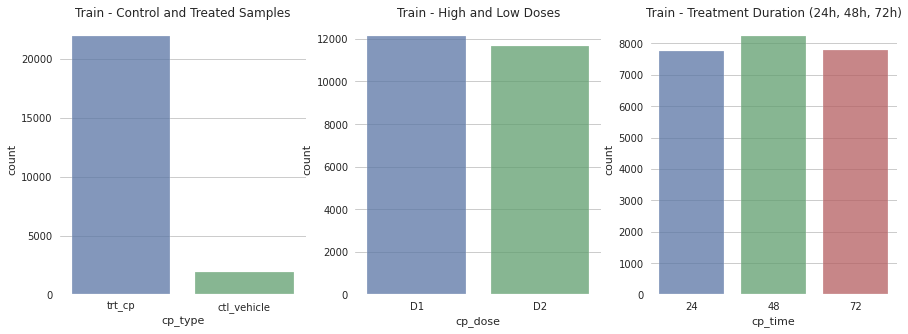

In [ ]:
plt.style.use('seaborn')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x='cp_type', data=train_features_df, alpha=0.75)
plt.title('Train - Control and Treated Samples')

plt.subplot(1, 3, 2)
sns.countplot(x='cp_dose', data=train_features_df, alpha=0.75)
plt.title('Train - High and Low Doses')

plt.subplot(1, 3, 3)
sns.countplot(x='cp_time', data=train_features_df, alpha=0.75)
plt.title('Train - Treatment Duration (24h, 48h, 72h)')

- `cp_type`: Most samples are with compound treatment
- `cp_dose`: Doses are evenly distributed with D1 slightly higher than D2
- `cp_time`: Treatment times are evenly distributed with `48h` slighltly higher than the rest

Both `cp_dose` and `cp_time` are quite balanced datasets. Now, we'll look at the **Numerical** features which consist of `Gene Expression` and `Cell Viability`

Number of gene features: 772


<Figure size 576x396 with 0 Axes>

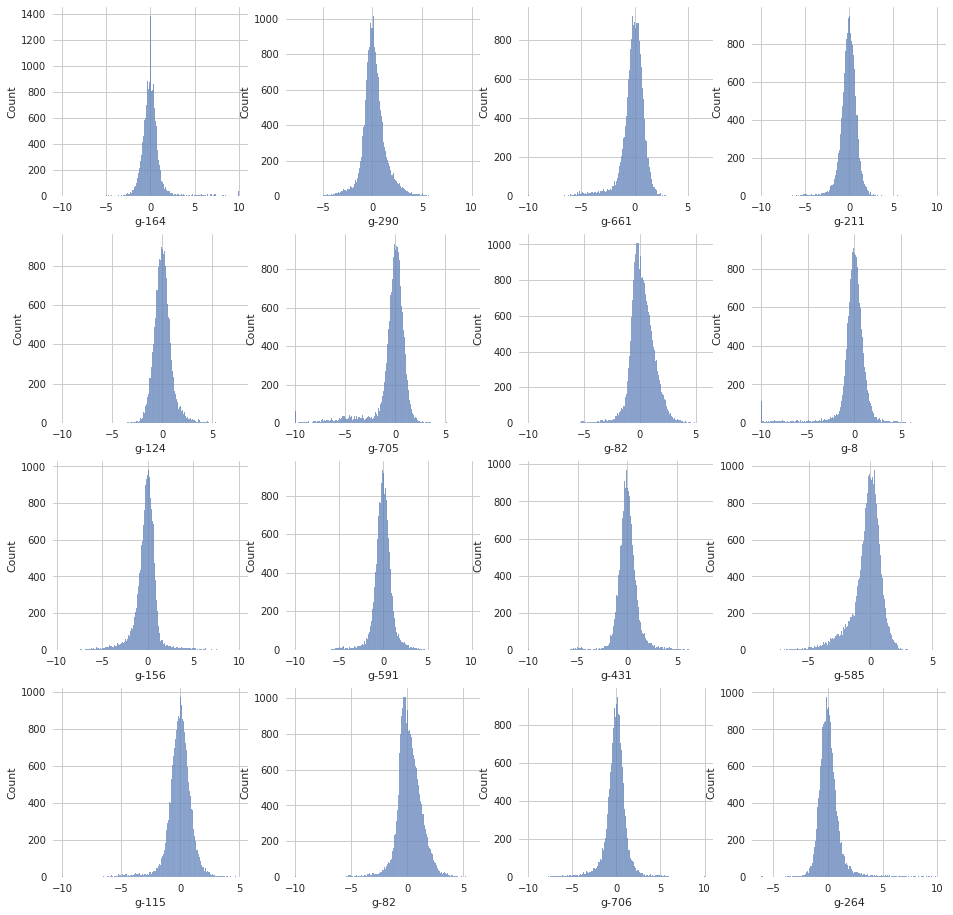

In [ ]:
genes = [gene for gene in train_features_df.columns if gene.startswith('g-')]
print(f"Number of gene features: {len(genes)}")

plt.figure(figsize=(16, 16))
genes_to_display = np.random.choice(len(genes), 16)

for i, col in enumerate(genes_to_display):
  gene = 'g-' + str(col)
  plt.subplot(4, 4, i+1)
  sns.histplot(x=gene, data=train_features_df)

Number of cell viability features: 100


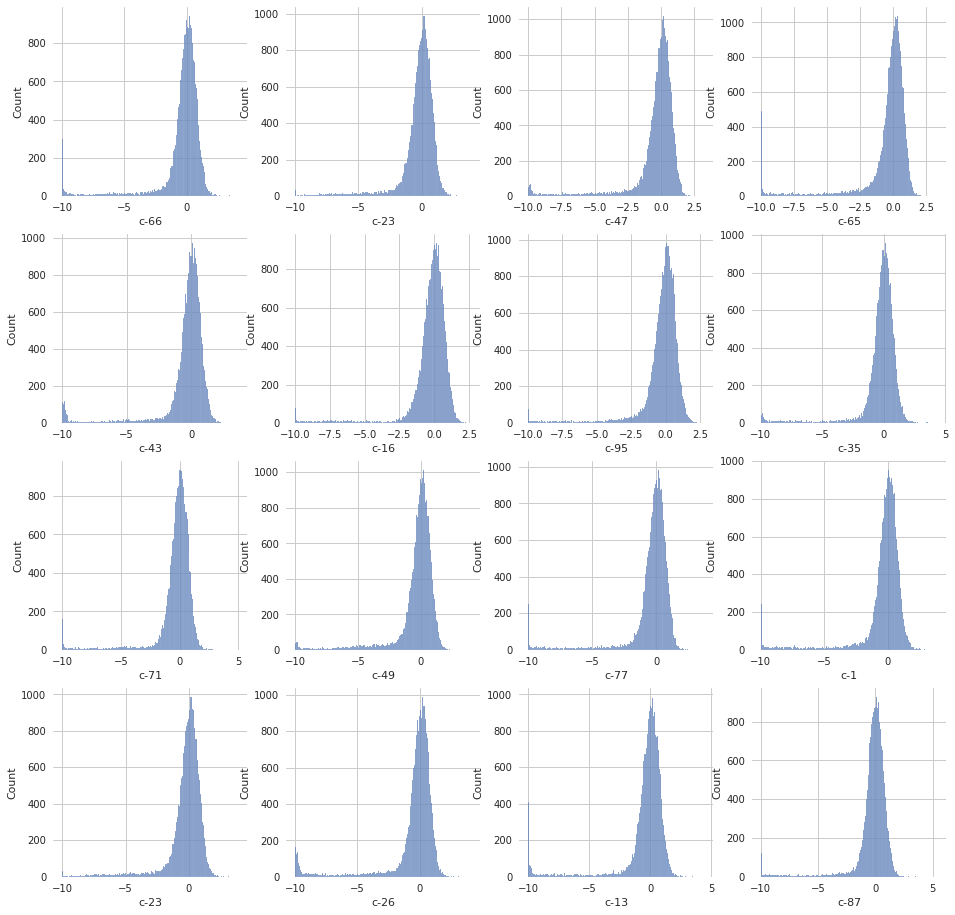

In [ ]:
cells = [cell for cell in train_features_df.columns if cell.startswith('c-')]
print(f"Number of cell viability features: {len(cells)}")

plt.figure(figsize=(16, 16))
cells_to_display = np.random.choice(len(cells), 16)

for i, col in enumerate(cells_to_display):
  cell = 'c-' + str(col)
  plt.subplot(4, 4, i+1)
  sns.histplot(x=cell, data=train_features_df)

- Both `g-` & `c-`: zero-centered, clipped at -10
- Gene expression cell viability should be between 0 and 1. Yet, here the values are in the range of -10 and 6 since the data was quantile normalized.

*A high negative cell viability measure reflects a high fraction of killing by the host*. In other words:
- High negative values = High number of dead cells
- High positive values = Hih number of living cells


### Correlation Analysis

For Gene expression data,

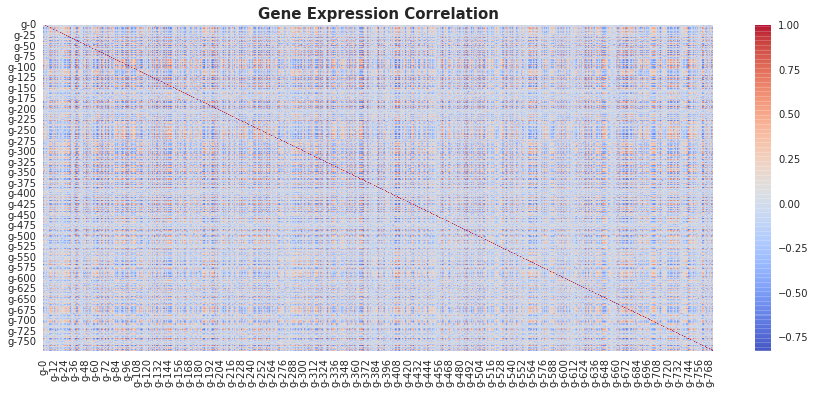

In [ ]:
# Treated samples
genes_treated = train_features_df[train_features_df['cp_type'] == 'trt_cp'][genes]

# Plot heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(genes_treated.corr(), cmap='coolwarm', alpha=0.75)
plt.title('Gene Expression Correlation', fontsize=15, weight='bold')
plt.show()

In [ ]:
# Get correlation table
def corrs(data, col1, col2, rows=10, thresh=0.9,
          pos=[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53]):
    #Correlation between genes
    corre=data.corr()
    #Unstack the dataframe
    s=corre.unstack()
    so=s.sort_values(kind='quicksort',ascending=False)
    #Create new dataframe
    so2=pd.DataFrame(so).reset_index()
    so2=so2.rename(columns={0:'correlation','level_0':col1,'level_1':col2})
    #Filter out the coef 1 correlation between the same drugs
    so2=so2[so2['correlation']!=1]
    #Drop pair duplicates
    so2=so2.reset_index()
    pos=pos
    so3=so2.drop(so2.index[pos])
    so3=so3.drop('index',axis=1)
    #Show the first 10 high correlations
    cm = sns.light_palette("pink", as_cmap=True)
    s = so3.head(rows).style.background_gradient(cmap=cm)
    print(f"{len(so2[so2['correlation']>thresh])/2} {col1} pairs have +{thresh} correlation.")
    return s

In [ ]:
corrs(genes_treated, 'Gene A', 'Gene B')

1.0 Gene A pairs have +0.9 correlation.


- One high correlation between `g-` features which needs to be taken into consideration for feature engineering

Now, let's look at `Cell Viability` data

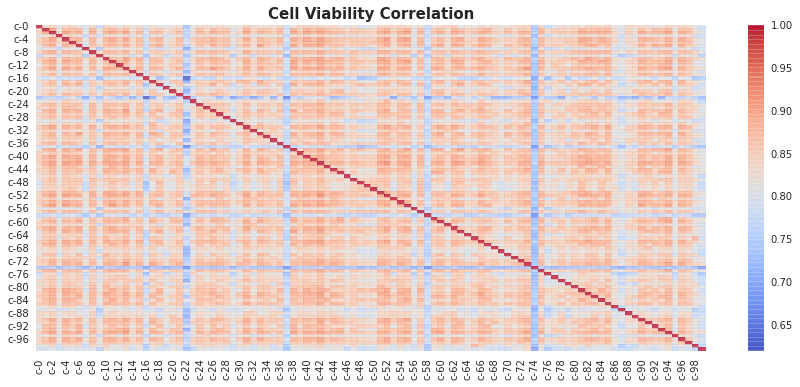

In [ ]:
# Only treated data
cells_treated = train_features_df[train_features_df['cp_type'] == 'trt_cp'][cells]

# Plot heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(cells_treated.corr(), cmap='coolwarm', alpha=0.75)
plt.title('Cell Viability Correlation', fontsize=15, weight='bold')
plt.show()

In [ ]:
corrs(cells_treated, 'Cell A', 'Cell B')

173.0 Cell A pairs have +0.9 correlation.


- Many features in `c-` have high correlation. This again needs to be looked at further for feature engineering

### Test Features

Text(0.5, 1.0, 'cp_time on test set')

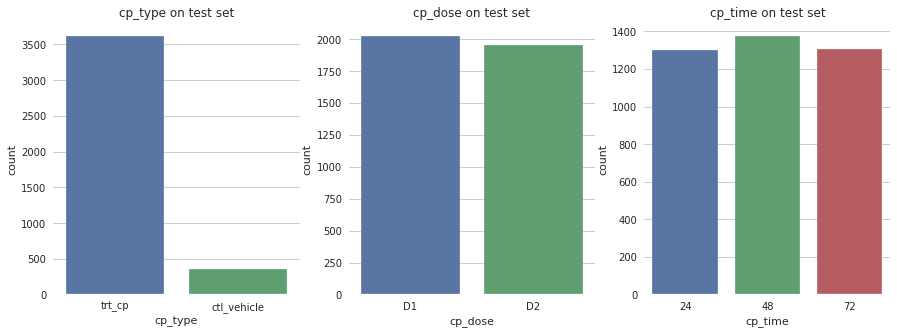

In [ ]:
plt.style.use("seaborn")
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.countplot(x='cp_type', data=test_features_df)
plt.title("cp_type on test set")

plt.subplot(1,3,2)
sns.countplot(x='cp_dose', data=test_features_df)
plt.title("cp_dose on test set")

plt.subplot(1,3,3)
sns.countplot(x='cp_time', data=test_features_df)
plt.title("cp_time on test set")

- Overall, it seems that both train and test datasets are similar in terms of *experimental conditions*. The variation would be in the gene expression and cell viability since the samples used in the test set are different than the ones in train set.


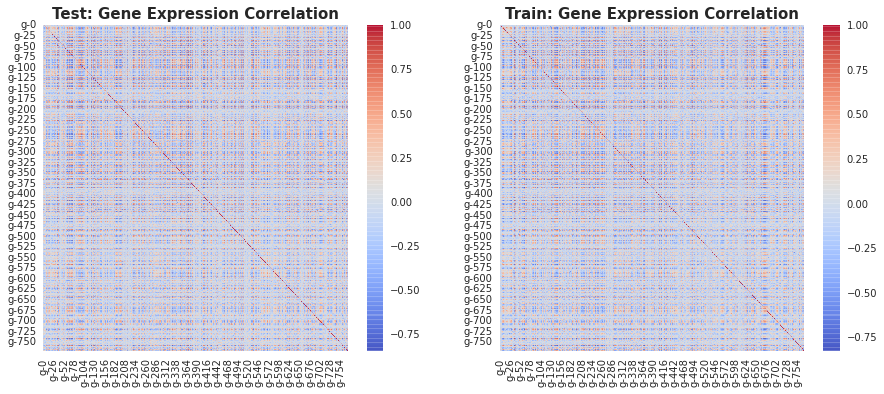

In [ ]:
# Treated samples
genes_treated_test = test_features_df[test_features_df['cp_type'] == 'trt_cp'][genes]

# Plot heatmap for train and test features
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(genes_treated_test.corr(), cmap='coolwarm', alpha=0.75)
plt.title('Test: Gene Expression Correlation', fontsize=15, weight='bold')

ax2 = plt.subplot(1, 2, 2)
sns.heatmap(genes_treated.corr(), cmap='coolwarm', alpha=0.75)
plt.title('Train: Gene Expression Correlation', fontsize=15, weight='bold')
plt.show()

In [ ]:
corrs(genes_treated_test, 'Gene A', 'Gene B')

1.0 Gene A pairs have +0.9 correlation.


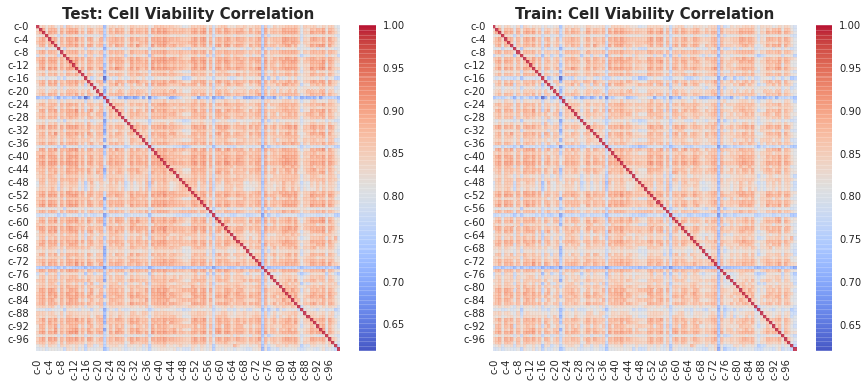

In [ ]:
# Treated samples
cells_treated_test = test_features_df[test_features_df['cp_type'] == 'trt_cp'][cells]

# Plot heatmap
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(cells_treated_test.corr(), cmap='coolwarm', alpha=0.75)
plt.title('Test: Cell Viability Correlation', fontsize=15, weight='bold')

ax2 = plt.subplot(1, 2, 2)
sns.heatmap(cells_treated.corr(), cmap='coolwarm', alpha=0.75)
plt.title('Train: Cell Viability Correlation', fontsize=15, weight='bold')
plt.show()

In [ ]:
corrs(cells_treated_test, 'Cell A', 'Cell B')

455.0 Cell A pairs have +0.9 correlation.


- `Test cell features` have better correlation than `Train cell features`
- The order of cells correlation is different in the test set
- Gene expression correlation is more similar in both train and test set

## Targets (MoA)

Target features are categorized into 2 groups; scored and non-scored target features, and features in both groups are binary. 

> **Scored targets**: This is a multi-label classification, we have 207 MoA and we have to find out the mechanism of action of the 5000 drugs that were treated in the sig_id samples. A single sample treated with a drug can have many active targets, in other words, one drug can have more than 1 mechanism of action, so we have to predict the mechanisms of action of each drug.

*We will filter the **train_targets_scored** dataset and keep just treated rows (discard the control rows because they're not treated with the drugs anyway)*.




In [ ]:
train_targets_scored_df.shape
train_targets_nonscored_df.shape

(23814, 403)

In [ ]:
display(train_targets_scored_df.head())
display(train_targets_scored_df.describe())

sig_id  ...  wnt_inhibitor
0  id_000644bb2  ...              0
1  id_000779bfc  ...              0
2  id_000a6266a  ...              0
3  id_0015fd391  ...              0
4  id_001626bd3  ...              0

[5 rows x 207 columns]

5-alpha_reductase_inhibitor  ...  wnt_inhibitor
count                 23814.000000  ...   23814.000000
mean                      0.000714  ...       0.001260
std                       0.026709  ...       0.035472
min                       0.000000  ...       0.000000
25%                       0.000000  ...       0.000000
50%                       0.000000  ...       0.000000
75%                       0.000000  ...       0.000000
max                       1.000000  ...       1.000000

[8 rows x 206 columns]

In [ ]:
display(train_targets_nonscored_df.head())
display(train_targets_nonscored_df.describe())

sig_id  ...  xiap_inhibitor
0  id_000644bb2  ...               0
1  id_000779bfc  ...               0
2  id_000a6266a  ...               0
3  id_0015fd391  ...               0
4  id_001626bd3  ...               0

[5 rows x 403 columns]

abc_transporter_expression_enhancer  ...  xiap_inhibitor
count                         23814.000000  ...    23814.000000
mean                              0.000252  ...        0.001008
std                               0.015871  ...        0.031731
min                               0.000000  ...        0.000000
25%                               0.000000  ...        0.000000
50%                               0.000000  ...        0.000000
75%                               0.000000  ...        0.000000
max                               1.000000  ...        1.000000

[8 rows x 402 columns]

In [ ]:
target_cols_scored=[col for col in train_targets_scored_df.columns if col not in ['sig_id']]
target_cols_nonscored=[col for col in train_targets_nonscored_df.columns if col not in ['sig_id']]

### Plot Distribution

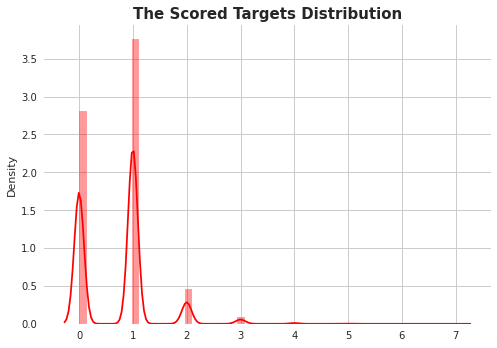

In [ ]:
sns.distplot(train_targets_scored_df[target_cols_scored].sum(axis=1), color='red')
plt.title('The Scored Targets Distribution', fontsize=15, weight='bold')
plt.show()

- All the targets are present in >= 1 sample
- The presence of each target is very low in all samples (Mostly < 0.75%)
- Some targets (*outliers*) have a higher presence in comparison with the rest of targets with a percentage in the range (3%, 4%).

Let's zoom in to some of the targets

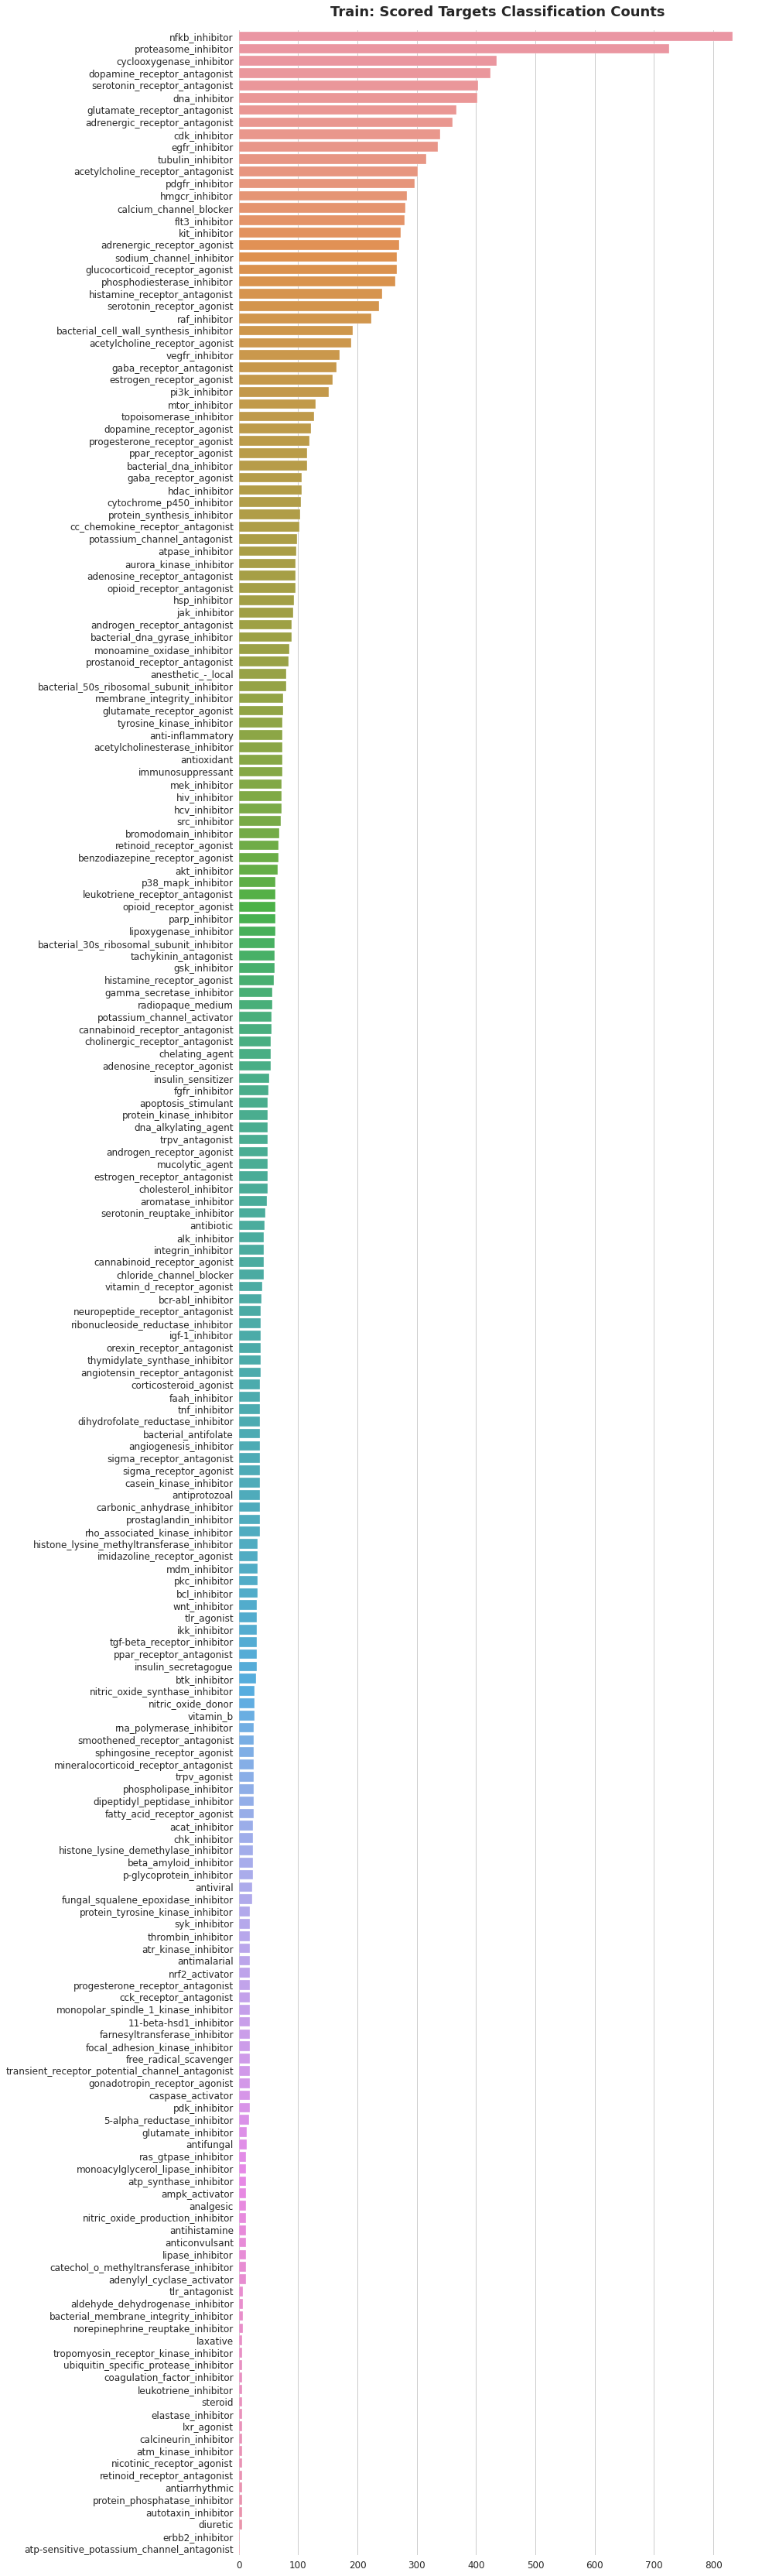

In [ ]:
fig = plt.figure(figsize=(12, 60))

sns.barplot(x=train_targets_scored_df[target_cols_scored].sum(axis=0).sort_values(ascending=False).values,
            y=train_targets_scored_df[target_cols_scored].sum(axis=0).sort_values(ascending=False).index)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Train: Scored Targets Classification Counts', size=18, pad=18, weight='bold')
plt.show()

- `nfkb_inhibitor` and `proteasome_inhibitor` seem to outliers
- There are 3 general target labels: inhibitor, agonist, and antagonist

### Correlation Analysis

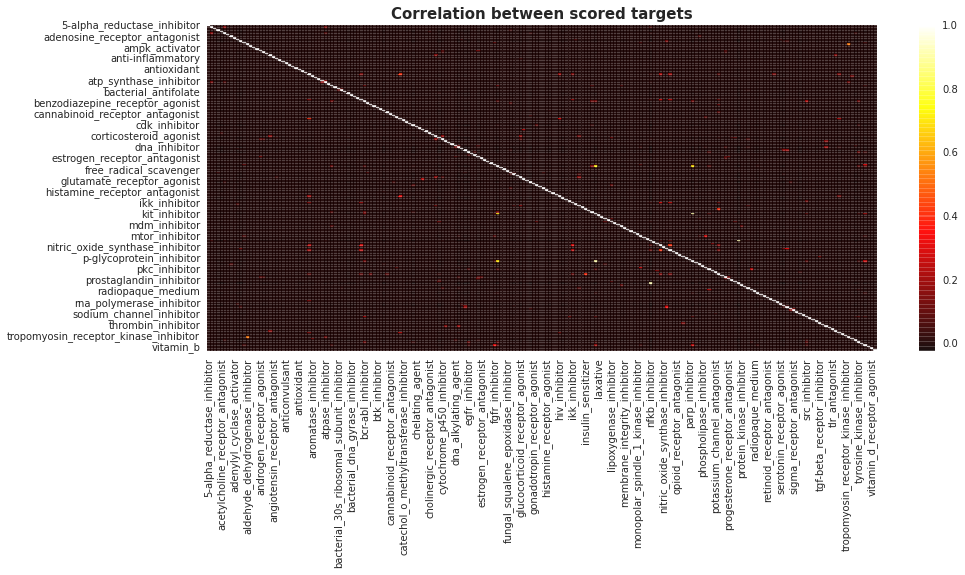

In [ ]:
plt.figure(figsize=(15, 6))
sns.heatmap(train_targets_scored_df[target_cols_scored].corr(), cmap='hot', alpha=0.75)
plt.title('Correlation between scored targets', fontsize=15, weight='bold')
plt.show()

- Most of these targets have 0 correlation. This may happen because the presence of active targets in the samples are very low (mainly 1 or 2 targets/sample).

- Nonetheless, there are targets with high correlation (yellow/orange dots). Let's zoom in to these targets

In [ ]:
corrs(train_targets_scored_df[target_cols_scored], 'Target A', 'Target B', rows=10)

2.0 Target A pairs have +0.9 correlation.


*Nonscored targets*: Not used for the score calculation in the Kaggle competition. It has 402 MoAs (> 206 MoAs in the targets_socred dataset that will be used in the score) 





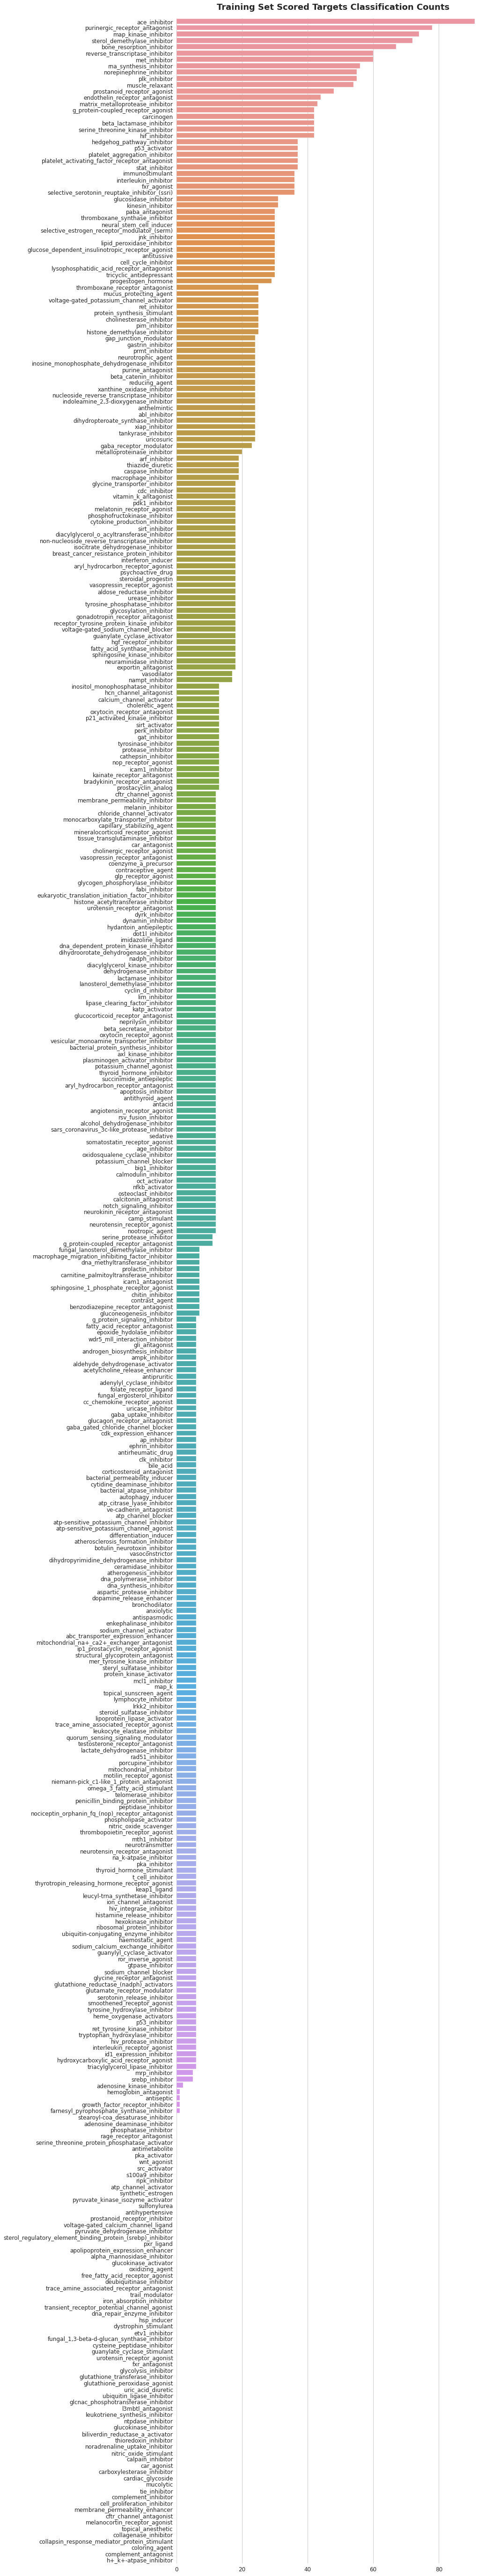

In [ ]:
fig = plt.figure(figsize=(12, 100))

sns.barplot(x=train_targets_nonscored_df[target_cols_nonscored].sum(axis=0).sort_values(ascending=False).values,
            y=train_targets_nonscored_df[target_cols_nonscored].sum(axis=0).sort_values(ascending=False).index)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Training Set Scored Targets Classification Counts', size=18, pad=18, weight='bold')
plt.show()

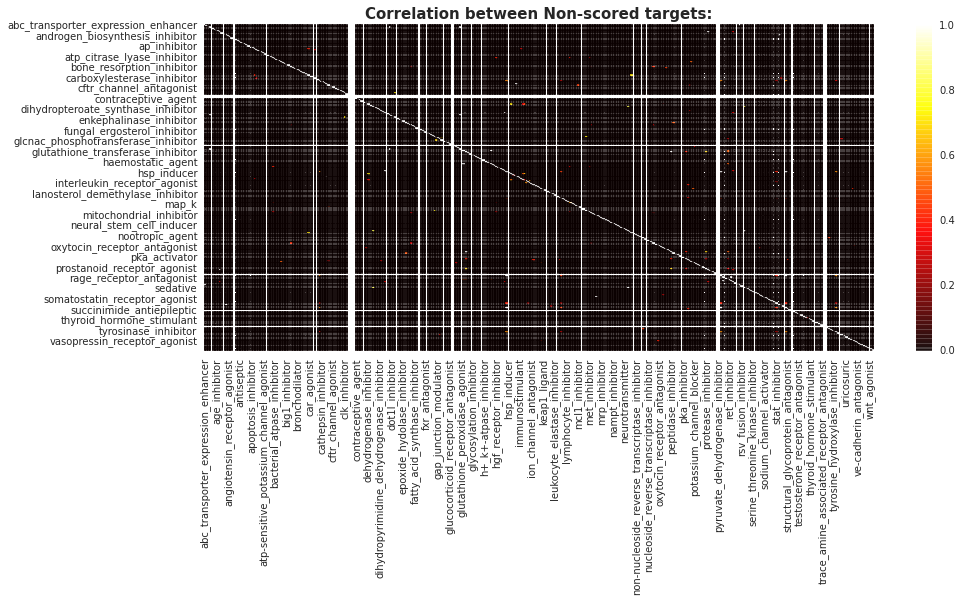

In [ ]:
plt.figure(figsize=(15,6))
sns.heatmap(train_targets_nonscored_df[target_cols_nonscored].corr(),cmap='hot',alpha=0.75)
plt.title('Correlation between Non-scored targets:', fontsize=15, weight='bold')
plt.show()

In [ ]:
corrs(train_targets_nonscored_df[target_cols_nonscored],'Target 1', 'Target 2')

0.0 Target 1 pairs have +0.9 correlation.


- Quite good correlation in Non-scored targets

Now, we can combine all the targets

### All Targets

In [ ]:
all_targets=train_targets_scored_df.merge(train_targets_nonscored_df, on='sig_id', how='left')
corrs(all_targets[target_cols_nonscored + target_cols_scored],
      'Target 1', 'Target 2')

2.0 Target 1 pairs have +0.9 correlation.


- We'll proceed with this combined targets dataset

## Drugs


> Drug IDs: `train_drug.csv` contains anonymous drug ids of every signature id in training set. There are 3289 unique drugs while there are 23814 unique signatures. This means some drugs are used more than 6 times (2 different doses x 3 different durations). This data can be useful for cross-validations and outlier detection.

### Count Drug


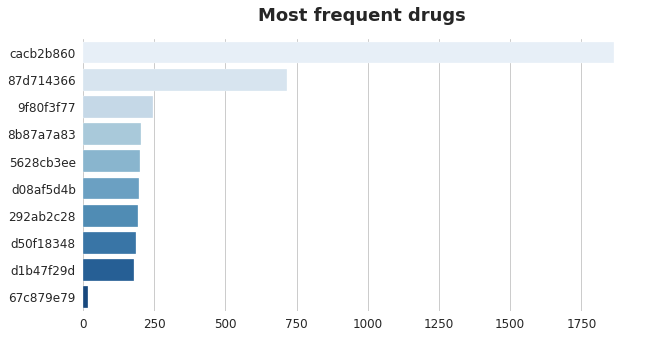

In [ ]:
fig = plt.figure(figsize=(10,5))

sns.barplot(x=train_drug_df['drug_id'].value_counts().values[:10],
            y=train_drug_df['drug_id'].value_counts().index[:10],palette = "Blues")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Most frequent drugs', size=18, pad=18, weight='bold')
plt.show()

In [ ]:
print('First observation:')
print(f"Number of rows of the Control vehicle is {len(train_features_df[train_features_df['cp_type']=='ctl_vehicle'])}")
print(f"Number of rows of the Drug cacb2b860 is {train_drug_df.drug_id.value_counts()[0]}")

First observation:
Number of rows of the Control vehicle is 1866
Number of rows of the Drug cacb2b860 is 1866


So, Drug cacb2b860 is the control vehicle, this explains its high presence in the train set. 

In [ ]:
drug_count = train_drug_df[['drug_id']].value_counts().to_frame()
drug_count = drug_count.rename(columns={0:'drug_count'})
drug_count2 = drug_count['drug_count'].value_counts().to_frame().reset_index()
drug_count2 = drug_count2.rename(columns={'index': 'Samples per drug', 'drug_count':'Number of Drugs'})
drug_count2[:12]

Samples per drug  Number of Drugs
0                  6             2774
1                  7              196
2                  1              129
3                  5               66
4                 12               64
5                 13               25
6                 14                6
7                 11                4
8                  8                4
9                  2                3
10                 4                3
11                18                3

- 2774 drugs out of 3700 drugs have 6 rows that correspond to 2 doses and 3 treatment times.
- Only 64 drugs have 12 samples.
- Only 3 drugs have 18 samples, the drugs were profiled 3 times.

## Conclusion

- Train and Test data have similar distribution
- Cell Features are highly correlated which means they can be used to create new features
- Data is quite skewed, which also means new features can be added
- `Drug_id` can play an important role for cross-validaton strategy as explained by this [thread](https://www.kaggle.com/c/lish-moa/discussion/195195). The Cross Validation strategy used here is Multi-label stratified Kfold.
- All Targets are highly correlated which can then be used for transfer learning
- About 71 Non-scored Targets don't have MoA so they can be dropped while pre-training